In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Application

In [3]:
from pyha.cores import FFTPower
from pyha.cores.util import *
plt.rcParams['figure.figsize'] = 15, 5

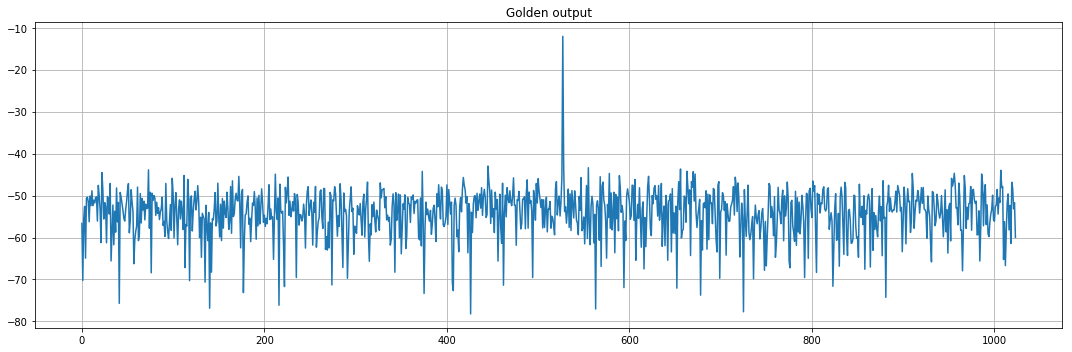

In [4]:
fft_size = 256
samples = 1024
freq = 15
sine = np.exp(2j*np.pi*np.linspace(0, 1, samples)*freq) * 0.25
noise = np.random.uniform(-1, 1, samples) + np.random.uniform(-1, 1, samples) * 1j
input_signal = sine + noise * 0.1

fft_result = np.fft.fft(input_signal) / len(input_signal)
power = (fft_result * np.conjugate(fft_result)).real
shift = np.fft.fftshift(power)
plt.title('Golden output')
plt.plot(np.log10(shift)*10)
show_plot()

## FFT to power

In [5]:
# NBVAL_IGNORE_OUTPUT
dut = FFTPower()
fft_sims = simulate(dut, fft_result, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1025/1025 [00:00<00:00, 27579.59it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [6]:
snr(fft_sims['MODEL'], fft_sims['PYHA'])

70.98910136032652

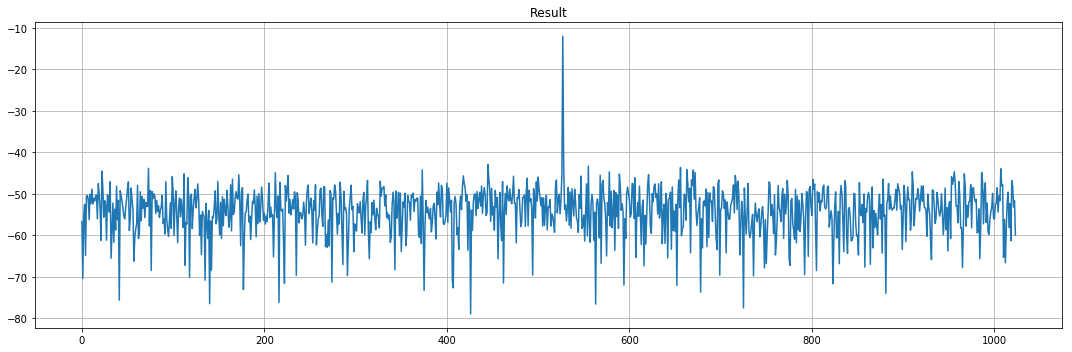

In [7]:
shift = np.fft.fftshift(fft_sims['PYHA'])
plt.title('Result')
plt.plot(np.log10(shift)*10)
show_plot()

# Limitations

## Uses `fullprecision` fixed-point output
Using normal precison leads to bugs when input signal power is low!

In [8]:
print(f'Minimum number representabe: {2**-35}')

Minimum number representabe: 2.9103830456733704e-11


## Input close to -1 .. 1 may saturate

In [9]:
# NBVAL_IGNORE_OUTPUT
input_signal = np.random.uniform(-1, 1, 128) + np.random.uniform(-1, 1, 128) * 1j
dut = FFTPower()
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


  0%|          | 0/129 [00:00<?, ?it/s]

100%|██████████| 129/129 [00:00<00:00, 5078.66it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


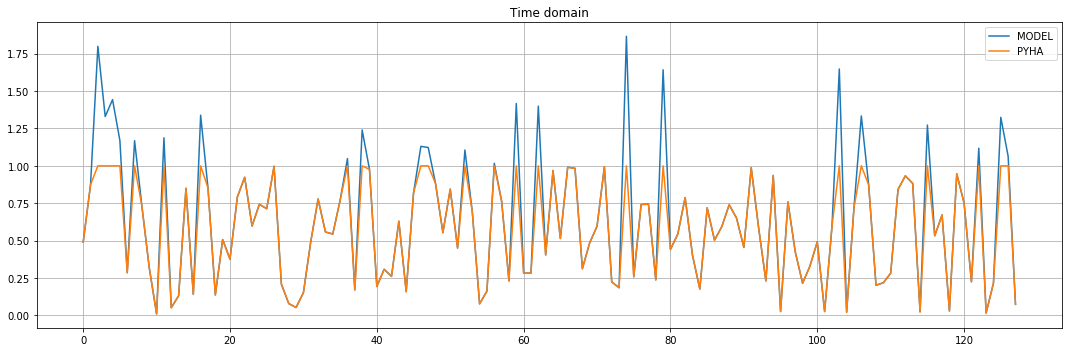

In [10]:
plt.title('Time domain')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

# Synthesis

In [11]:
# NBVAL_SKIP
dut = FFTPower()
sims = simulate(dut, fft_result, simulations=['MODEL', 'PYHA', 'RTL', 'GATE'])

assert sims_close(sims)
lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1025/1025 [00:00<00:00, 7647.58it/s]

INFO:sim:OK!
INFO:sim:Running "RTL" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataIndexValid to VHDL ...
INFO:conversion:DataIndexValid to VHDL ...
INFO:conversion:FFTPower to VHDL ...


INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataIndexValid to VHDL ...
INFO:conversion:DataIndexValid to VHDL ...
INFO:conversion:FFTPower to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Fri Aug 24 13:26:32 2018
INFO:sim:Quartus Prime Version : 18.0.0 Build 614 04/24/2018 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 123
INFO:sim:    Total combinational functions : 91
INFO:sim:    Dedicated logic registers : 68
INFO:sim:Total registers : 68
INFO:sim:Total pins : 140
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 0
INFO:sim:Embedded Multiplier 9-bit elements : 4
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:OK!
INFO:sim:Simulations c

Logic elements: 123
Memory: 0
Multipler (18bit): 2
